In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = np.loadtxt("../data/all_sensors_all_controls.csv", delimiter=",", skiprows=1)
print(data.shape)

(24021, 25)


<IPython.core.display.Javascript object>


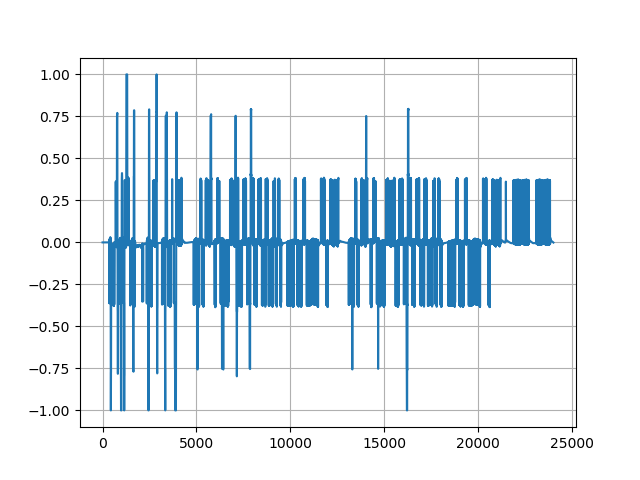

In [3]:
plt.figure()
plt.plot(data[:, 2])
plt.grid()

In [4]:
steer_labeled = np.zeros(len(data), dtype=int)
levels = [-1, -3/4, -1/3, 0, 1/3, 3/4, 1]
delta = 0.1
for i, d in enumerate(data[:, 2]):
    for label, level in enumerate(levels):
        if abs(level - d) <= 0.1:
            steer_labeled[i] = label
            continue

<IPython.core.display.Javascript object>


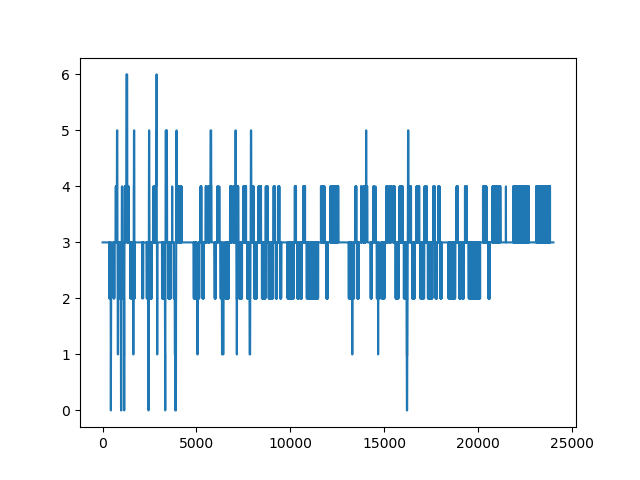

In [5]:
plt.figure()
plt.plot(steer_labeled)

In [6]:
from simple_esn import SimpleESN
X = data[:, 3:]
Y = steer_labeled.tolist()
split_idx = int(0.7 * len(X))

X_train = X[:split_idx]
y_train = Y[:split_idx]
X_test = X[split_idx:]
y_test = Y[split_idx:]

# Simple training
n_readout = 500
my_esn = SimpleESN(n_readout=n_readout, n_components=n_readout,
                   damping=0.5, weight_scaling=1.0)
echo_train = my_esn.fit_transform(X_train)

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.autograd as autograd

class SteeringClassifier(nn.Module):
    def __init__(self, n_inputs, n_hidden, n_outputs):
        super(SteeringClassifier, self).__init__()
        
        self.linear1 = nn.Linear(n_inputs, n_hidden)
        self.linear2 = nn.Linear(n_hidden, n_outputs)
    
    def forward(self, inputs):
        h = F.tanh(self.linear1(inputs.view(1, -1)))
        y = self.linear2(h)
        log_probs = F.log_softmax(y)
        return log_probs

In [18]:
model = SteeringClassifier(n_readout, 100, 7)
loss_function = nn.NLLLoss()
optimizer = optim.Adam(model.parameters())

EPOCHS = 20
for epoch in range(EPOCHS):
    total_loss = 0
    for i in range(len(echo_train)):
        log_probs = model(autograd.Variable(torch.FloatTensor(echo_train[i])))
        train_loss = loss_function(log_probs, autograd.Variable(torch.LongTensor([y_train[i]])))
        total_loss += train_loss.data[0]
        
        model.zero_grad()
        train_loss.backward()
        optimizer.step()
    print("{:d} - {:.2f}".format(epoch+1, total_loss))

1 - 4297.17
2 - 1970.75
3 - 1624.48
4 - 1524.44
5 - 1431.45
6 - 1408.20
7 - 1403.47
8 - 1297.13
9 - 1247.13
10 - 1247.23
11 - 1191.78
12 - 1210.66
13 - 1185.22
14 - 1110.54
15 - 1079.98
16 - 1085.93
17 - 993.80
18 - 1012.92
19 - 1011.61
20 - 1013.31


In [74]:
correct = 0
for n, data in enumerate(echo_train):
    v, i = model(autograd.Variable(torch.FloatTensor(data))).data.max(1)
    if i[0] == y_train[n]:
        correct += 1
print("Accuracy: {:.1f}%".format(100 * correct/len(predictions)))

Accuracy: 96.5%
